# 加载依赖项目

In [16]:
import dataloader as data
from torch.utils.data import  Dataset,random_split,DataLoader
import torch.nn as nn
import utile
import torch
import time
import torchvision.models as models
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 超参数

In [17]:
lr = 0.0001
batch_size= 128
num_worker = 0
epoch_num=1000

# 加载数据集

In [18]:
train_t = data.TrafficDataset()
test_t = data.TrafficDataset(train=False)
train_set = train_t.construct_set()
test_set = test_t.construct_set()
train_loader = DataLoader(train_set,batch_size=batch_size,shuffle=True,num_workers=num_worker,drop_last=True)

test_loader = DataLoader(test_set,batch_size=batch_size,shuffle=True,num_workers=num_worker,drop_last=True)

(1920, 10, 20, 2)
(960, 10, 20, 2)


# 构造网络

In [19]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, drop_prob):
        super(Net, self).__init__()

        self.resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)  # 您可以选择不同的 ResNet 架构
        self.resnet.fc = nn.Identity()  # 移除全连接层

        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            batch_first=True,
                            num_layers=2)

        self.attention = nn.MultiheadAttention(embed_dim=576, num_heads=8)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(2304, output_size)

    def forward(self, x):
        x = x.to(device)
        x = x.view(x.shape[0], x.shape[1], 2, 10, 20)
        x = x.transpose(1, 2)

        cnn_feats = self.resnet(x.contiguous().view(-1, 3, 10, 20))
        cnn_feats = cnn_feats.contiguous().view(x.shape[0], -1, cnn_feats.shape[-1])

        gru_out, _ = self.lstm(x.contiguous().view(x.shape[0], x.shape[1], -1))
        gru_feats = torch.mean(gru_out, dim=1)

        fusion_feats = torch.cat((cnn_feats, gru_feats.unsqueeze(1).expand(-1, cnn_feats.size(1), -1)), dim=-1)

        # Permute dimensions to match the expected shape for MultiheadAttention
        fusion_feats = fusion_feats.permute(1, 0, 2)
        att_output, _ = self.attention(fusion_feats, fusion_feats, fusion_feats)
        att_output = att_output.permute(1, 0, 2)

        x = self.fc(self.dropout(att_output.reshape(batch_size,-1)))
        return torch.sigmoid(x)


In [20]:
rmse, mae = [], []
train_loss=[]
test_loss=[]
start_time = time.time()
net = Net(
    input_size=1200,
    hidden_size=64,
    output_size=400,
    drop_prob=0.5).to(device)
loss = nn.MSELoss()
opt =  torch.optim.Adam(lr = lr,params=net.parameters())
for epoch in range(epoch_num):
    loss_list = []
    for x,y in train_loader:
        if x.shape[0] < batch_size:
            continue
        y = y.view(batch_size,-1).to(device)
        y_hat= net(x)
        # print(y_hat.size())

        l= loss(y_hat,y)

        opt.zero_grad()
        l.backward()
        opt.step()
        loss_list.append(l.item())
    train_loss_mean = np.mean(loss_list)
    train_loss.append(train_loss_mean)
    loss_list = []
    rmse_list, mae_list = [], []
    for x,y in test_loader:
        if x.shape[0] < batch_size:
            continue
        y = y.view(batch_size,-1).to(device)
        y_hat= net(x)
        l= loss(y_hat,y)

        y = test_t.denormalize(y)
        y_hat = test_t.denormalize(y_hat)
        rmse_a, mae_a = utile.eval(y.detach(), y_hat.detach())
        rmse_list.append(rmse_a)
        mae_list.append(mae_a)
        loss_list.append(l.item())

    test_loss_mean = np.mean(loss_list)
    test_loss.append(test_loss_mean)
    rmse.append(np.mean(rmse_list))
    mae.append(np.mean(mae_list))

    print("epoch:", epoch + 1, "\n",
              "train_loss:", train_loss_mean, "test_loss:", test_loss_mean,
                "\n",
              "mae:",np.mean(mae_list),
              "rmse:",np.mean(rmse_list)
              )

epoch: 1 
 train_loss: 0.09971756827352303 test_loss: 0.006600655415760619 
 mae: 48.851112 rmse: 104.70342212358969
epoch: 2 
 train_loss: 0.005679696931370667 test_loss: 0.006017660322998252 
 mae: 36.699917 rmse: 99.97904245927874
epoch: 3 
 train_loss: 0.004995568189769983 test_loss: 0.004379035771957466 
 mae: 32.747307 rmse: 85.27936142976526
epoch: 4 
 train_loss: 0.003563793559026505 test_loss: 0.003230436971145017 
 mae: 39.38756 rmse: 73.25220037364417
epoch: 5 
 train_loss: 0.00297529499844781 test_loss: 0.002878839981609157 
 mae: 36.26209 rmse: 69.14813258226982
epoch: 6 
 train_loss: 0.002589613847833659 test_loss: 0.002404319222218224 
 mae: 31.677145 rmse: 63.19690704639036
epoch: 7 
 train_loss: 0.0021534072667626397 test_loss: 0.0020415083106075016 
 mae: 29.395903 rmse: 58.23661545119859
epoch: 8 
 train_loss: 0.0018900111982864992 test_loss: 0.0019260884561975087 
 mae: 28.352024 rmse: 56.52708931225203
epoch: 9 
 train_loss: 0.0017565579951873847 test_loss: 0.00179

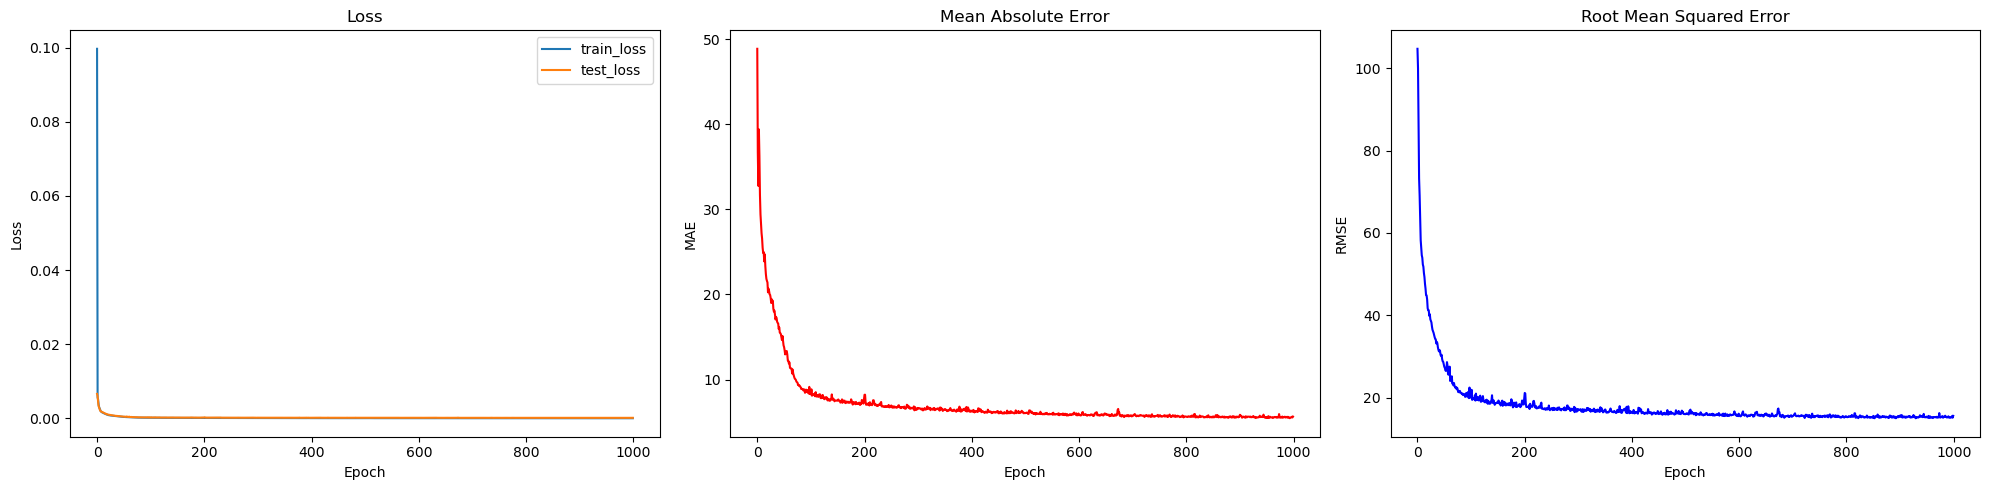

In [21]:
utile.show_result(train_loss,test_loss,mae,rmse)